#### ***Importing the libraries***

In [8]:
import pandas as pd
import numpy as np 
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt
import random

#### ***Connection to MongoDB***

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["yelp"]

#### ***Queries***

##### ***Query 1***
How many businesses and reviews are there for each category?

In [64]:
#By working directly on the "businesses_merged" collection
b_and_r_per_category = db["businesses_merged"].aggregate([{
                                                              "$unwind" : "$categories"
                                                          },
                                                          {
                                                              "$unwind" : "$reviews"
                                                          },
                                                          {
                                                              "$group" : {
                                                                  "_id" : "$categories",
                                                                  "num_reviews" : {
                                                                      "$sum" : 1
                                                                  },
                                                                  "ids" : {
                                                                      "$addToSet" : "$business_id"
                                                                  }
                                                              }
                                                          },
                                                          {
                                                              "$project" : {
                                                                  "_id" : 0,
                                                                  "category" : "$_id",
                                                                  "num_businesses" : {
                                                                      "$size" : "$ids"
                                                                  },
                                                                  "num_reviews" : 1
                                                              }
                                                          },
                                                          {
                                                              "$sort" : {
                                                                  "num_businesses" : -1,
                                                                  "num_reviews" : -1
                                                              }
                                                          }])
 
query_df = pd.DataFrame(b_and_r_per_category)
query_df

,num_reviews,category,num_businesses
0,4724464,Restaurants,52268
1,1813588,Food,27781
2,523251,Shopping,24395
3,238255,Home Services,14356
4,370120,Beauty & Spas,14292
...,...,...,...
1307,5,DUI Schools,1
1308,5,Ceremonial Clothing,1
1309,5,Makerspaces,1
1310,5,Interlock Systems,1


In [ ]:
#By working separetely on "businesses" and "reviewes" collections, putting results togheter with Pandas
businesses_per_category = db["businesses"].aggregate([{
                                                          "$unwind" : "$categories"
                                                      },
                                                      {
                                                          "$group" : {
                                                              "_id" : "$categories",
                                                              "num_businesses" : {
                                                                  "$sum" : 1
                                                              }
                                                          }
                                                      },
                                                      {
                                                          "$project" : {
                                                              "_id" : 0,
                                                              "category" : "$_id",
                                                              "num_businesses" : 1
                                                          }
                                                      }])

business_df = pd.DataFrame(businesses_per_category)

reviews_per_category = db["reviews"].aggregate([{
                                                    #In $lookup stage, we are performing a sort of join between "reviews" and "businesses" collections
                                                    "$lookup" : { 
                                                        "from" : "businesses", #"from" specifies the collection to join with "reviews"

                                                        #With "let" we are defining a new variable to use in the following steps
                                                        "let" : { 
                                                            "id" : "$business_id" #"business_id" from "reviews" collection becomes a variable named
                                                        },

                                                        #"pipeline" defines criteria to filter the joined documents
                                                        "pipeline" : [{
                                                                            "$match" : { 
                                                                                #In match we cannot write "x : y" with both x and y document's fields, so we need an equal ($eq) expression ($expr)
                                                                                "$expr" : { 
                                                                                    "$eq" : ["$business_id", "$$id"] #Actual join operation, check that "business_id" (b_id) in "reviews" is the same as "business_id" in "businesses" collections
                                                                                }                                                    
                                                                            }   
                                                                        }],

                                                        #Specifies the field in the output document where the matching documents from "businesses" will be added; it will be an array.
                                                        "as" : "business" 
                                                    }
                                                 },
                                                 {
                                                     "$unwind" : "$business"
                                                 },
                                                 {
                                                     "$unwind" : "$business.categories"
                                                 },
                                                 {
                                                     "$group" : {
                                                         "_id" : "$business.categories",
                                                         "num_reviews" : {
                                                             "$sum" : 1
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$project" : {
                                                         "_id" : 0,
                                                         "category" : "$_id",
                                                         "num_reviews" : 1
                                                     }
                                                 }])
 
reviews_df = pd.DataFrame(reviews_per_category)

df = pd.merge(business_df, reviews_df, on = "category", how = "inner")
df = df[["category", "num_businesses", "num_reviews"]]
df = df.sort_values(by = ["num_businesses", "num_reviews"], ascending = False)
df

In [ ]:
#By looking up on "businesses" from "reviews" and adding to a set the business_id for each category
b_and_r_per_category = db["reviews"].aggregate([{
                                                    "$lookup" : { 
                                                        "from" : "businesses",
                                                        "let" : { 
                                                            "id" : "$business_id"
                                                        },
                                                        "pipeline" : [{
                                                                            "$match" : { 
                                                                            "$expr" : { 
                                                                                "$eq" : ["$business_id", "$$id"]
                                                                            }                                                    
                                                                            }   
                                                                        }],
                                                        "as" : "business" 
                                                    }
                                                 },
                                                 {
                                                     "$unwind" : "$business"
                                                 },
                                                 {
                                                     "$unwind" : "$business.categories"
                                                 },
                                                 {
                                                     "$group" : {
                                                         "_id" : "$business.categories",
                                                         "num_reviews" : {
                                                             "$sum" : 1
                                                         },
                                                         "ids" : {
                                                             "$addToSet" : "$business.business_id"
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$project" : {
                                                         "_id" : 0,
                                                         "category" : "$_id",
                                                         "num_businesses" : {
                                                             "$size" : "$ids"
                                                         },
                                                         "num_reviews" : 1
                                                     }
                                                 },
                                                 {
                                                     "$sort" : {
                                                         "num_businesses" : -1,
                                                         "num_reviews" : -1
                                                     }
                                                 }])
 
df = pd.DataFrame(b_and_r_per_category)
df

##### ***Query 2***

A polarizing business is a one with high variance in star ratings. For each category, find the most polarizing businesses.

In [ ]:
query_results = db["businesses_merged"].aggregate([{
                                                       "$unwind" : "$categories"
                                                   },
                                                   {
                                                       "$unwind" : "$reviews"
                                                   },                                      
                                                   { 
                                                       "$group" : {
                                                           "_id" : {
                                                               "r_id" : "$business_id",
                                                               "category" : "$categories"
                                                           },
                                                           "name" : {
                                                               "$first" : "$name"
                                                           },
                                                           "avg_stars" : {
                                                               "$avg": "$reviews.stars"
                                                           },
                                                           "variance" : {
                                                               "$stdDevPop": "$reviews.stars" 
                                                           },
                                                           "num_reviews" : {
                                                               "$sum" : 1
                                                           } 
                                                       }
                                                   },
                                                   {
                                                        "$sort" : {
                                                            "category" : 1,
                                                            "variance" : -1
                                                        }
                                                    },
                                                    {
                                                        "$group" : {
                                                            "_id" : "$_id.category",
                                                            "name" : {
                                                                "$first" : "$name"
                                                            },
                                                            "variance" : {
                                                                "$first" : "$variance"
                                                            },
                                                            "avg_stars" : {
                                                                "$first": "$avg_stars"
                                                            },
                                                            "num_reviews" : {
                                                                "$first": "$num_reviews"
                                                            }
                                                        }
                                                    },
                                                   {
                                                       "$project" : {
                                                           "_id" : 0,
                                                           "category" : "$_id",
                                                           "name" : 1,
                                                           "avg_stars" : 1,
                                                           "num_reviews" : 1,
                                                           "variance" : 1,
                                                       }
                                                   },
                                                   {
                                                       "$sort" : {
                                                           "variance" : -1
                                                       }
                                                   }])
 
#Store the result in a DataFrame
df = pd.DataFrame(query_results)
df

,name,variance,avg_stars,num_reviews,category
0,Vanderbilt Walk In Clinic,2.0,3.0,10,Medical Centers
1,Vanderbilt Walk In Clinic,2.0,3.0,10,Urgent Care
2,Vanderbilt Walk In Clinic,2.0,3.0,10,Health & Medical
3,Pro Video TV Repair,2.0,3.0,10,Appliances & Repair
4,Pro Video TV Repair,2.0,3.0,10,Electronics Repair
...,...,...,...,...,...
1307,Gators Parasail,0.0,5.0,66,Sport Equipment Hire
1308,Exit Tactics,0.0,5.0,13,Bubble Soccer
1309,Myers Metal Detectors,0.0,5.0,6,Metal Detector Services
1310,Hazzan Cantor Howard K Glantz,0.0,5.0,15,Mohels


In [163]:
#TODO: make a histogram
df.iloc[30]


name            Juicy Puff
variance               2.0
avg_stars              3.0
num_reviews              6
category       Hookah Bars
Name: 30, dtype: object

##### ***Query 3***

For businesses that operate in different locations (we assume that these are the ones for which there are two objects in ```businesses``` collection with same ```name```, but different ```city```), determine in which city they perform the best in terms of average star ratings.

In [109]:
more_than_one_city = db["businesses"].aggregate([{
                                                     "$group" : {
                                                         "_id" : {
                                                             "name" : "$name", 
                                                         },
                                                         "cities" : {
                                                             "$addToSet" : "$city"
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$match" : {
                                                         "$expr" : {
                                                             "$gt" : [{"$size" : "$cities"}, 1]
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$project" : {
                                                         "_id" : 0,
                                                         "name" : "$_id.name",
                                                         "num_cities" : {"$size" : "$cities"}
                                                     }
                                                 }])

ratings = db["businesses_merged"].aggregate([{
                                                 "$unwind" : "$reviews" 
                                             },
                                             {
                                                 "$group" : {
                                                     "_id" : {
                                                         "name" : "$name", 
                                                         "city" : "$city" 
                                                     },
                                                     "avg_stars" : {
                                                         "$avg" : "$reviews.stars" 
                                                     }
                                                 }
                                             },
                                             {
                                                 "$project" : {
                                                     "_id" : 0,
                                                     "name" : "$_id.name",
                                                     "city" : "$_id.city",
                                                     "avg_stars" : 1
                                                 }
                                             },
                                             {
                                                 "$sort" : {
                                                     "name" : 1,
                                                     "avg_stars" : -1
                                                 }
                                             },
                                             {
                                                 "$group" : {
                                                     "_id" : "$name",
                                                     "city" : { 
                                                         "$first" : "$city"
                                                     },
                                                     "avg_stars" : {
                                                         "$first" : "$avg_stars"
                                                     }
                                                 }
                                             },
                                             {
                                                 "$project" : {
                                                     "_id" : 0,
                                                     "name" : "$_id",
                                                     "city" : 1,
                                                     "avg_stars" : 1
                                                 }
                                             }])
  
more_than_one_city = pd.DataFrame(more_than_one_city)

#Keep only the businesses present in more than one city
df = pd.DataFrame(ratings)
df = df[df["name"].isin(more_than_one_city["name"])]
df

,city,avg_stars,name
26,Overland,3.866667,Nail Art
63,Fishers,4.460000,Main Street Poké
66,Sparks,3.421053,SKECHERS Factory Outlet
142,Haverford,4.857143,Lithe Method
159,Cinnaminson,3.526316,MedExpress Urgent Care
...,...,...,...
114031,Philadelphia,3.937107,Randazzo's Pizzeria
114045,Pottstown,3.714286,Little Sicily
114051,Ballwin,4.186047,Defy
114054,Saint Louis,4.600000,Mattress Direct


##### ***Query 4***
We define businesses $b_1$ an $b_2$ *competitors* if $b_1.\text{city}=b_2city$ and $b_1.categories \cap b_2.categories \neq \{\emptyset\}$. Determine if there is a relation between the average (variance) of reviews' stars and the number of competitors for the most widespread businesses. 

In [185]:
competitors = db["businesses"].aggregate([{
                                              "$unwind" : "$categories"
                                          },
                                          {
                                              "$group" : {
                                                  "_id" : {
                                                      "city" :"$city",
                                                      "category" : "$categories"
                                                  },
                                                  "businesses_names" : {
                                                      "$addToSet" : "$name"
                                                  }
                                              }
                                          },
                                          {
                                              "$addFields" : {
                                                  "businesses_names_copy" : "$businesses_names"
                                              }
                                          },
                                          {
                                              "$unwind" : "$businesses_names"
                                          },
                                          {
                                              "$group" : {
                                                  "_id" : {
                                                      "name" : "$businesses_names",
                                                      "city" : "$_id.city"
                                                  },
                                                  "possible_competitors" : {
                                                      "$addToSet" : "$businesses_names_copy"
                                                  }
                                              }
                                          },
                                          {
                                              "$project" : { #Maybe here is better to use directly -1
                                                  "_id" : 1,
                                                  "possible_competitors" : {
                                                      "$filter" : {
                                                          "input" : "$possible_competitors",
                                                          "as" : "pc",
                                                          "cond" : {"$ne" : ["$$pc", "$_id.name"]}
                                                      }
                                                  }
                                              }
                                          },
                                          {
                                              "$addFields" : {
                                                  "num_competitors" : {
                                                      "$size" : "$possible_competitors"
                                                  }
                                              }
                                          },
                                          {
                                              "$project" : {
                                                  "_id" : 0,
                                                  "city" : "$_id.city",
                                                  "name" : "$_id.name",
                                                  "num_competitors" : 1
                                              }
                                          }])

ratings = db["businesses_merged"].aggregate([{
                                                 "$unwind" : "$reviews" 
                                             },
                                             {
                                                 "$group" : {
                                                     "_id" : {
                                                         "name" : "$name", 
                                                         "city" : "$city" 
                                                     },
                                                     "avg_stars" : {
                                                         "$avg" : "$reviews.stars" 
                                                     },
                                                     "star_variance" : {
                                                         "$stdDevPop" : "$reviews.stars"
                                                     }

                                                 }
                                             },
                                             {
                                                 "$project" : {
                                                     "_id" : 0,
                                                     "name" : "$_id.name",
                                                     "city" : "$_id.city",
                                                     "avg_stars" : 1,
                                                     "star_variance" : 1
                                                 }
                                             }])

#Keep only the businesses present in more than one city
ratings_df = pd.DataFrame(ratings)

competitors_df = pd.DataFrame(competitors)

#Merge the two DFs
df = pd.merge(ratings_df, competitors_df, left_on = ["name", "city"], right_on = ["name", "city"])
df

,avg_stars,star_variance,name,city,num_competitors
0,4.483516,0.761182,Anderson Orchard,Mooresville,4
1,2.826087,1.614756,Little Philadelphia,Reno,4
2,5.000000,0.000000,SMART Solutions,Tampa,5
3,4.163551,0.998306,The Libertine Liquor Bar,Indianapolis,5
4,3.261905,1.773610,Luxury Nails,Indianapolis,5
...,...,...,...,...,...
137241,4.600000,1.200000,Toxic Ranch,Tucson,5
137242,2.714286,1.749636,Wesley Chapel Dentistry,Wesley Chapel,6
137243,4.578947,0.815365,The Original Barbershop NPR,New Port Richey,2
137244,4.428571,1.399708,AR Workshop Tampa,Tampa,7


Average stars:


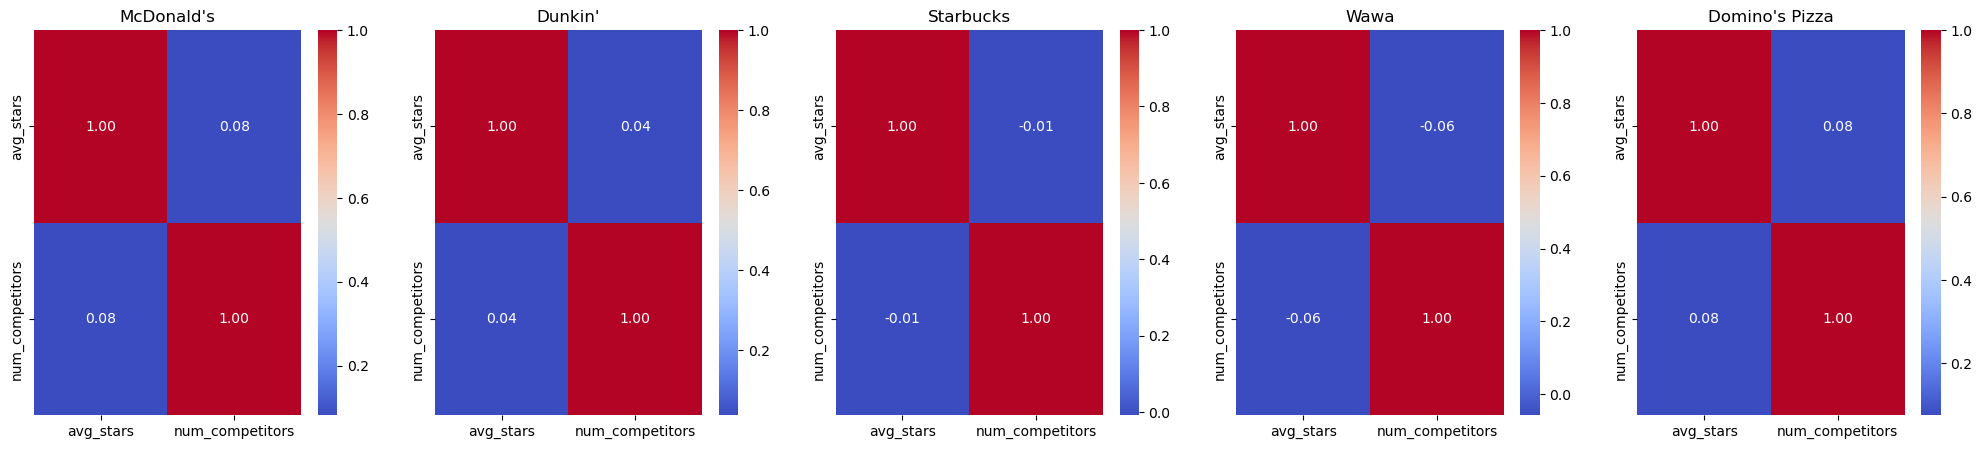

Variance of stars:


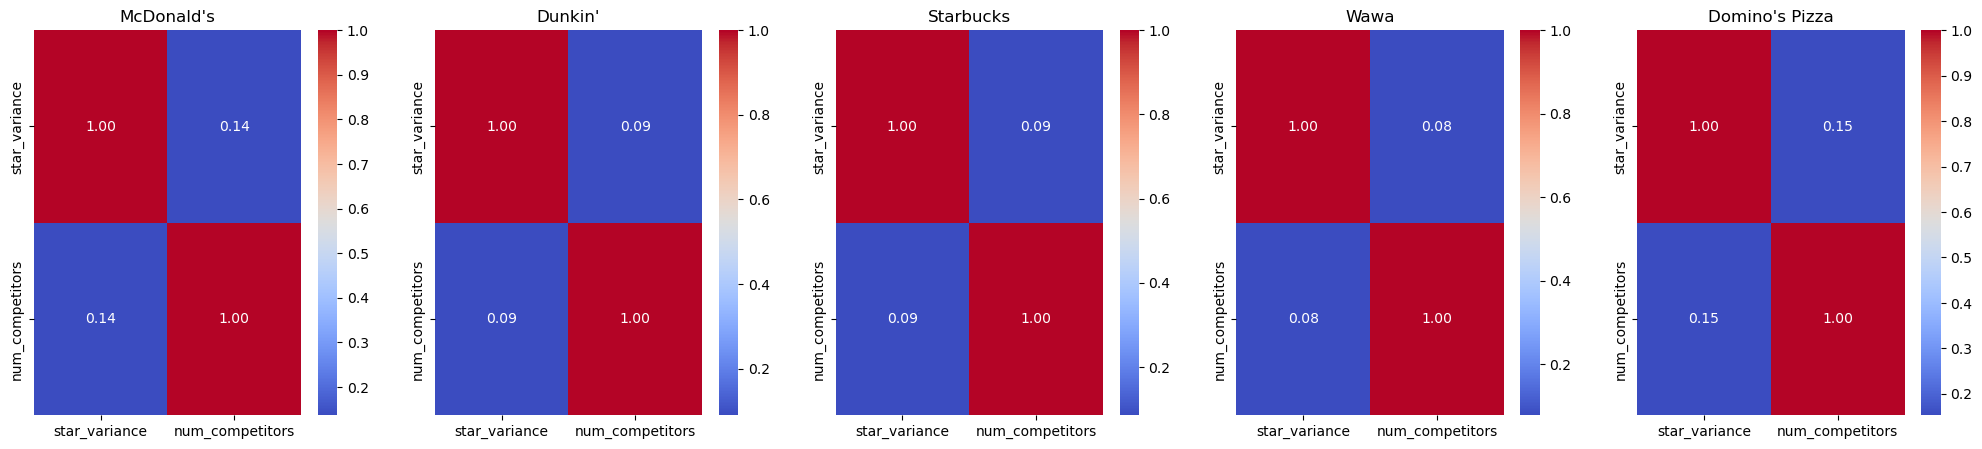

In [200]:
#Find the most widespread businesses
to_look_for = df.groupby("name").size().reset_index("name")
to_look_for.columns = ["name", "count"]
to_look_for = to_look_for.sort_values(by = "count", ascending = False)

#Consider only first 5 for plotting reasons
to_look_for = list(to_look_for["name"][:5])

fig, axs = plt.subplots(1, 5, figsize = (25, 5))

print("Average stars:")

for j in range(5):
    current_data = df[df["name"] == to_look_for[j]]
    
    correlation_matrix = current_data[["avg_stars", "num_competitors"]].corr()

    sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", ax = axs[j])
    axs[j].set_title(to_look_for[j])

plt.show()

fig, axs = plt.subplots(1, 5, figsize = (25, 5))

print("Variance of stars:")

for j in range(5):
    current_data = df[df["name"] == to_look_for[j]]

    correlation_matrix = current_data[["star_variance", "num_competitors"]].corr()

    sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", ax = axs[j])
    axs[j].set_title(to_look_for[j])

plt.show()

##### ***Query 5***
Discover if night reviews and day reviews are biased, that is show how the difference between their average values is distributed.

In [304]:
night_reviews = db["reviews"].aggregate([{
                                             "$addFields" : {
                                                 "review_hour" : {
                                                     "$hour": "$date"
                                                 }
                                             }
                                         },
                                         {
                                             "$match" : {
                                                 "$or" : [
                                                     {"review_hour" : {"$gte" : 22}},
                                                     {"review_hour" : {"$lte" : 5}}
                                                 ]
                                             }
                                         },
                                         {
                                             "$group" : {
                                                 "_id" : "$user_id",
                                                 "num_night_reviews" : {
                                                     "$sum" : 1
                                                 },
                                                 "avg_night_ratings" : {
                                                     "$avg" : "$stars"
                                                 }
                                             }
                                         },
                                         {
                                             "$project" : {
                                                 "_id" : 0,
                                                 "user_id" : "$_id",
                                                 "num_night_reviews" : 1,
                                                 "avg_night_ratings" : 1
                                             }
                                         }])

day_reviews = db["reviews"].aggregate([{
                                           "$addFields" : {
                                               "review_hour" : {
                                                   "$hour": "$date"
                                               }
                                           }
                                       },
                                       {
                                           "$match" : {
                                               "$and" : [
                                                     {"review_hour" : {"$lt" : 22}},
                                                     {"review_hour" : {"$gt" : 5}}
                                                 ]
                                           }
                                       },
                                       {
                                           "$group" : {
                                               "_id" : "$user_id",
                                               "num_day_reviews" : {
                                                   "$sum" : 1
                                               },
                                               "avg_day_ratings" : {
                                                   "$avg" : "$stars"
                                               }
                                           }
                                       },
                                       {
                                           "$project" : {
                                               "_id" : 0,
                                               "user_id" : "$_id",
                                               "num_day_reviews" : 1,
                                               "avg_day_ratings" : 1
                                           }
                                       }])

night_reviews = pd.DataFrame(night_reviews)
day_reviews = pd.DataFrame(day_reviews)

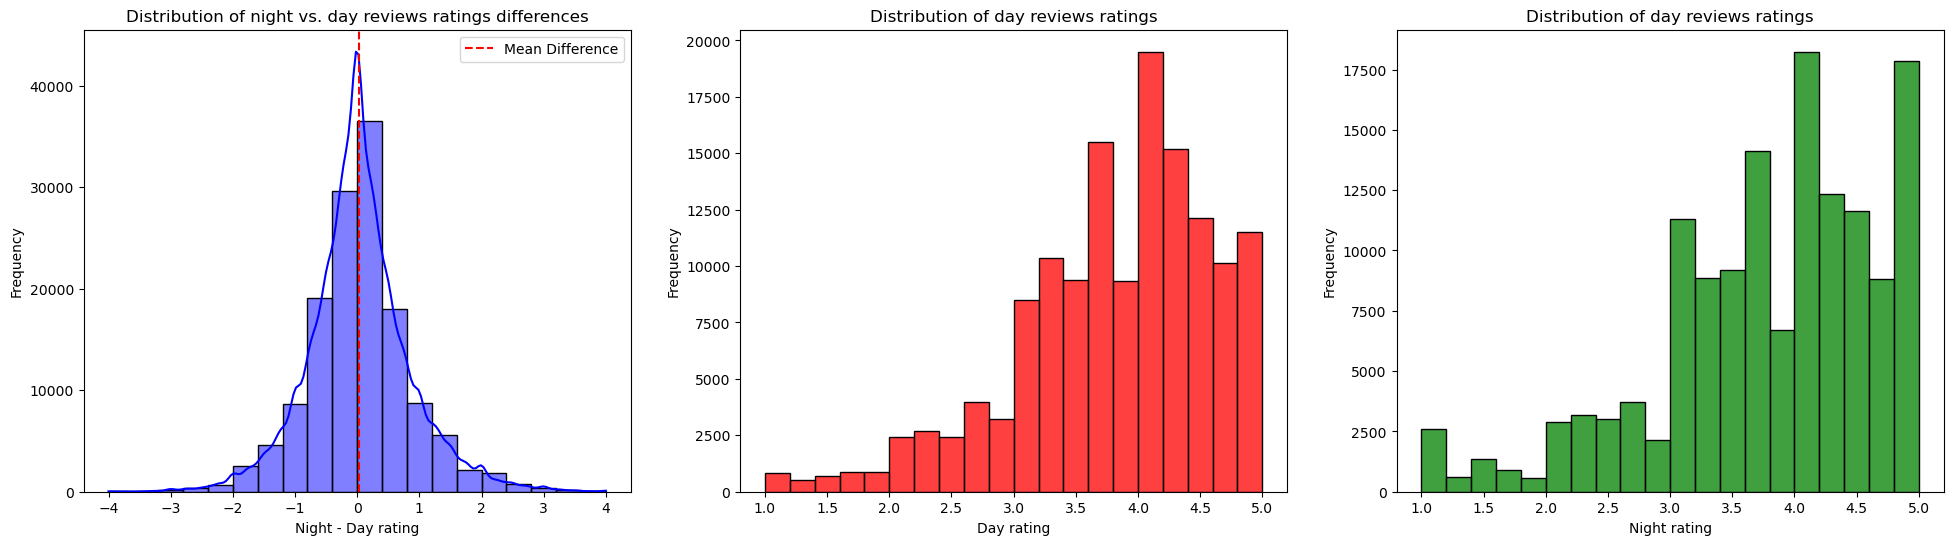

In [306]:
#Merge the two DFs basing on "user_id" column
df = pd.merge(day_reviews, night_reviews, on = "user_id", how = "inner")

#Select a representative sample (users who have written at least 4 reviews in day hours and 2 in night hours)
repr = df.where((df["num_day_reviews"] >= 4) & 
                (df["num_night_reviews"] >= 2))

diff = repr["avg_day_ratings"] - repr["avg_night_ratings"]

fig, axs = plt.subplots(1, 3, figsize = (24, 6))

#Histogram for night - day reviews ratings
sns.histplot(diff, kde = True, bins = 20, color = "blue", ax = axs[0])
axs[0].axvline(diff.mean(), color = "red", linestyle = "--", label = "Mean Difference")
axs[0].set_title("Distribution of night vs. day reviews ratings differences")
axs[0].set_xlabel("Night - Day rating")
axs[0].set_ylabel("Frequency")
axs[0].legend()

#Histogram for night - day reviews ratings
sns.histplot(repr["avg_day_ratings"], color = "red", bins = 20, ax = axs[1])
axs[1].set_title("Distribution of day reviews ratings")
axs[1].set_xlabel("Day rating")
axs[1].set_ylabel("Frequency")

#Histogram for night - day reviews ratings
sns.histplot(repr["avg_night_ratings"], color = "green", bins = 20, ax = axs[2])
axs[2].set_title("Distribution of day reviews ratings")
axs[2].set_xlabel("Night rating")
axs[2].set_ylabel("Frequency")

plt.show()

In [301]:
#Same result can be obtained with the following query
query_results = db["reviews"].aggregate([{
                                             "$addFields" : {
                                                 "reviewHour" : {
                                                     "$hour": "$date"
                                                 }
                                             }
                                         },
                                         {
                                             "$addFields" : { 
                                                 "is_night" : {
                                                     "$or" : [
                                                         {"$gte": ["$reviewHour", 22]}, 
                                                         {"$lt": ["$reviewHour", 5]}
                                                     ]
                                                 }
                                             }
                                         },
                                         { 
                                             "$group" : {
                                                 "_id" : "$user_id",
                                                 "num_night_reviews" : {
                                                     "$sum" : {
                                                         "$cond" : ["$is_night", 1, 0] 
                                                     }
                                                 },
                                                 "num_day_reviews" : {
                                                     "$sum" : {
                                                         "$cond" : ["$is_night", 0, 1]
                                                     }
                                                 },
                                                 "avg_night_ratings" : {
                                                     "$avg" : {
                                                         "$cond" : ["$is_night", "$stars", None] 
                                                     } 
                                                 },
                                                 "avg_day_ratings" : {
                                                     "$avg" : {
                                                         "$cond" : ["$is_night", None, "$stars"]
                                                     }
                                                 }
                                             }
                                         },
                                         { 
                                             "$match": {
                                                 "num_night_reviews" : {
                                                     "$gte": 2
                                                 },
                                                 "num_day_reviews" : {
                                                     "$gte": 4
                                                 },
                                             }
                                         },
                                         { 
                                             "$project" : {
                                                 "_id": 0,
                                                 "user_id": "$_id",
                                                 "num_night_reviews": 1,
                                                 "num_day_reviews": 1,
                                                 "avg_night_ratings": 1,
                                                 "avg_day_ratings": 1
                                             }
                                         }
                                     ])

df = pd.DataFrame(query_results)
df

,num_night_reviews,num_day_reviews,avg_night_ratings,avg_day_ratings,user_id
0,8,20,5.000000,5.000000,---2PmXbF47D870stH1jqA
1,5,6,2.800000,4.333333,---UgP94gokyCDuB5zUssA
2,2,4,4.500000,3.500000,--17Db1K-KujRuN7hY9Z0Q
3,2,6,3.000000,3.000000,--2tyArRmSoyKx5r-FVG0A
4,3,19,4.333333,4.368421,--2vR0DIsmQ6WfcSzKWigw
...,...,...,...,...,...
142144,4,11,4.000000,4.454545,zzqVInn9-mjoj7diZLFNkQ
142145,4,4,4.000000,5.000000,zzrhWsiCwAKQzbgMZIOtgg
142146,10,8,4.200000,3.875000,zzsPf8xNW11nd0B6MZqfRw
142147,18,24,4.611111,3.875000,zztkCqqgR6VntYbqio4UTQ


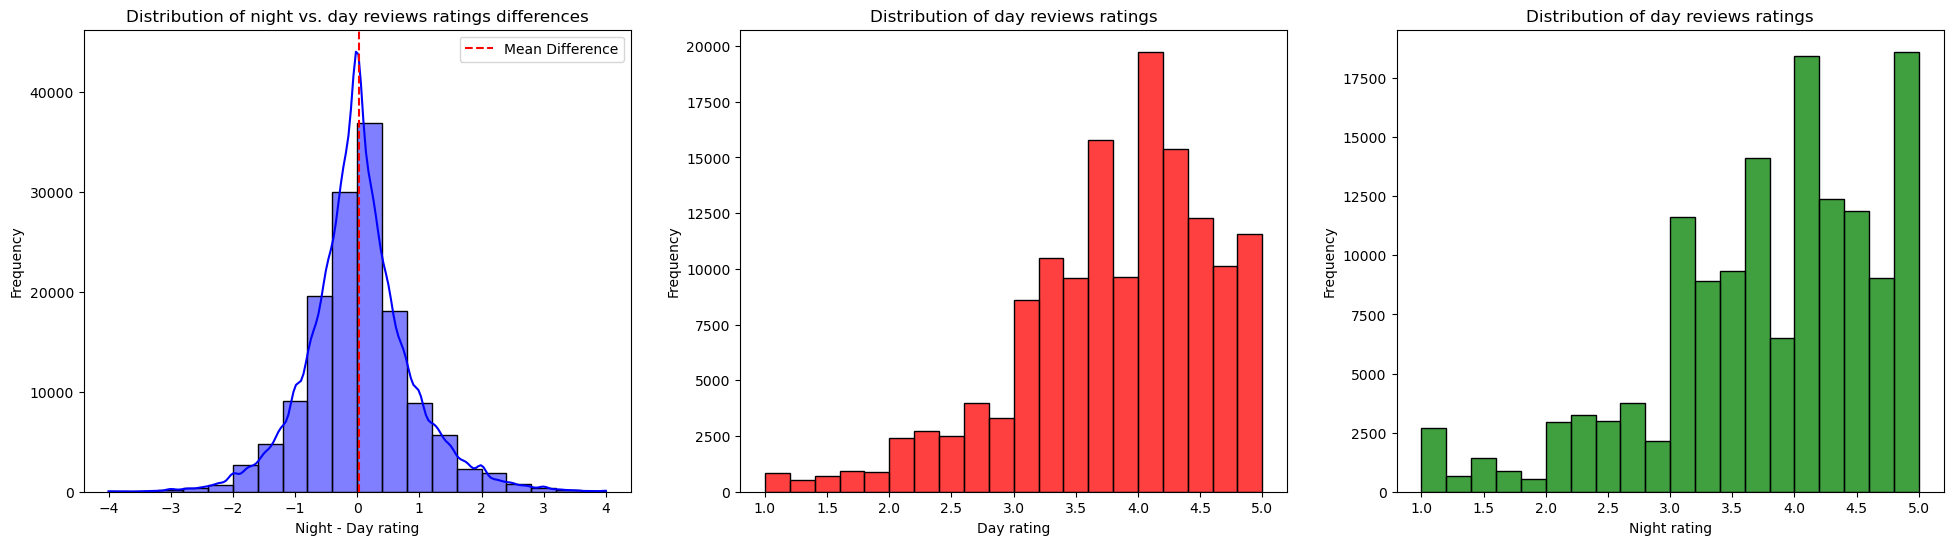

In [303]:
fig, axs = plt.subplots(1, 3, figsize = (24, 6))

diff = df["avg_day_ratings"] - df["avg_night_ratings"]

#Histogram for night - day reviews ratings
sns.histplot(diff, kde = True, bins = 20, color = "blue", ax = axs[0])
axs[0].axvline(diff.mean(), color = "red", linestyle = "--", label = "Mean Difference")
axs[0].set_title("Distribution of night vs. day reviews ratings differences")
axs[0].set_xlabel("Night - Day rating")
axs[0].set_ylabel("Frequency")
axs[0].legend()

#Histogram for night - day reviews ratings
sns.histplot(df["avg_day_ratings"], color = "red", bins = 20, ax = axs[1])
axs[1].set_title("Distribution of day reviews ratings")
axs[1].set_xlabel("Day rating")
axs[1].set_ylabel("Frequency")

#Histogram for night - day reviews ratings
sns.histplot(df["avg_night_ratings"], color = "green", bins = 20, ax = axs[2])
axs[2].set_title("Distribution of day reviews ratings")
axs[2].set_xlabel("Night rating")
axs[2].set_ylabel("Frequency")

plt.show()

##### ***Query 6***
Friends  have similar ratings? For businesses they have both reviewed, compute the difference between their average ratings.

In [100]:
avg_rating = db["businesses_merged"].aggregate([{
                                                    "$unwind" : "$reviews"
                                                },
                                                {
                                                    "$group" : {
                                                        "_id" : {
                                                            "user_id" : "$reviews.user_id",
                                                            "business_id" : "$business_id"
                                                        },
                                                        "avg_rating" : {
                                                            "$avg" : "$reviews.stars"
                                                        }
                                                    }
                                                },
                                                {
                                                    "$match" : {
                                                        "avg_rating" : {
                                                            "$ne" : None
                                                        }
                                                    }
                                                },
                                                {
                                                    "$project" : {
                                                        "_id" : 0,
                                                        "user_id" : "$_id.user_id",
                                                        "business_id" : "$_id.business_id",
                                                        "avg_rating" : 1
                                                    }
                                                }])

common_reviewed = db["users_merged"].aggregate([{
                                                     "$project" : {
                                                         "user_id" : 1,
                                                         "reviews" : "$reviews.business_id",
                                                         "friends" : 1
                                                     }
                                                 },
                                                 {
                                                     "$lookup" : {
                                                         "from" : "users_merged",
                                                         "localField" : "friends",
                                                         "foreignField" : "user_id",
                                                         "pipeline" : [{
                                                             "$project" : {
                                                                 "user_id" : 1,
                                                                 "reviews" : "$reviews.business_id"
                                                             }
                                                         }],
                                                         "as" : "friend_reviews"
                                                     }
                                                 },
                                                 {
                                                     "$addFields" : {
                                                         "shared_reviews" : {
                                                             "$map" : {
                                                                 "input" : "$friend_reviews",
                                                                 "as" : "f_r",
                                                                 "in" : {
                                                                     "friend_id" : "$$f_r.user_id",
                                                                     "businesses" : {
                                                                         "$setIntersection" : ["$reviews", "$$f_r.reviews"]
                                                                     }
                                                                 }
                                                             }
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$addFields" : {
                                                         "shared_reviews" : {
                                                             "$filter" : {
                                                                 "input" : "$shared_reviews",
                                                                 "as" : "s_r",
                                                                 "cond" : {
                                                                     "$gt": [{"$size": "$$s_r.businesses"}, 0]
                                                                 }
                                                             }
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$unwind" : "$shared_reviews"
                                                 },
                                                 {
                                                     "$project": {
                                                         "_id" : 0,
                                                         "user_id" : 1,
                                                         "shared_reviews" : 1
                                                     }
                                                 }])

#common_reviewed = pd.DataFrame(common_reviewed)
avg_rating = pd.DataFrame(avg_rating)
avg_rating

,avg_rating,user_id,business_id
0,5.0,---1lKK3aKOuomHnwAkAow,f19eLfhXqR47Ct8Hz2y_pA
1,5.0,---2PmXbF47D870stH1jqA,0ZsqqzHu1HHkDdIKoivi5g
2,5.0,---2PmXbF47D870stH1jqA,1An4DxtMmvvSe0HX4viRCA
3,5.0,---2PmXbF47D870stH1jqA,3YqUe2FTCQr0pPVK8oCv6Q
4,5.0,---2PmXbF47D870stH1jqA,3gXgILE2YWVidJDvVWBT6Q
...,...,...,...
6745722,4.0,zzz-M4QvkEpUWWPL9RTzLA,qO-r-NipYXcuVXjIbaglEQ
6745723,5.0,zzzCg-_lpyYE82TlJCdwdw,LttC5xNMFcgOg3bt_MlXTg
6745724,3.0,zzzGgfvrSJ4AQeKtcgocIw,XyYsl2OyoMi6OMvzsdcVoQ
6745725,1.0,zzzMBVS73g3ZJ7qL8JyhiA,3FKIev7ZB_KE6XHL9sUJCg


In [ ]:
avg_rating_dict = (avg_rating.reset_index()
                   .groupby("user_id")
                   .apply(lambda g: dict(zip(g["business_id"], g["avg_rating"])))
                   .to_dict())

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_35572\4228840078.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: dict(zip(g['business_id'], g['avg_rating'])))


In [ ]:
#Attention: it might take long!

result = []

for doc in common_reviewed:
    user_id = doc["user_id"]
    friend_id = doc["shared_reviews"]["friend_id"]
    businesses = doc["shared_reviews"]["businesses"]
    
    # Retrieve ratings directly from the dictionary
    avg_user_ratings = [avg_rating_dict.get(user_id, {}).get(b, float("nan")) for b in businesses]
    avg_friend_ratings = [avg_rating_dict.get(friend_id, {}).get(b, float("nan")) for b in businesses]
    
    result.append({
        "user_id": user_id,
        "friend_id": friend_id,
        "avg_rating_user": pd.Series(avg_user_ratings).mean(),
        "avg_rating_friend": pd.Series(avg_friend_ratings).mean()
    })

#result_df = pd.DataFrame(result)

In [110]:
result_df = pd.DataFrame(result)
result_df

,user_id,friend_id,avg_rating_user,avg_rating_friend
0,qVc8ODYU5SZjKXVBgXdI7w,-0SqALqeWmInVftG_iHcHg,5.0,4.0
1,qVc8ODYU5SZjKXVBgXdI7w,-vQsYbUmdtL9GB3z3ZG0tw,4.0,2.0
2,qVc8ODYU5SZjKXVBgXdI7w,0m-7A68bctvAHXPhMEazTg,5.0,2.0
3,qVc8ODYU5SZjKXVBgXdI7w,0yYCMhDWCEIVUyZLzDWwqQ,5.0,3.5
4,qVc8ODYU5SZjKXVBgXdI7w,1JLeCtVa2-i7aH5aC4bF2w,5.0,5.0
...,...,...,...,...
1067665,Wq2ZxDUbOMmuSQIWGPC60A,4xpo1s-gb9SeJg4ppSzobA,4.0,5.0
1067666,Un9IgydB67um2VtC6TvvVw,iu4cazC32xlyUcFBSYWgCA,1.0,1.0
1067667,qMD-Qxw7ntTHnAkGMiNv5A,WB1ZKk3CnF3j7_QjLyQoxA,1.0,1.0
1067668,n8YZ-f_4waehfbmEb0lA1w,WwulXySQN8t2hwqH_yWurA,5.0,5.0


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_35572\1221804631.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta$ rewievs stars")


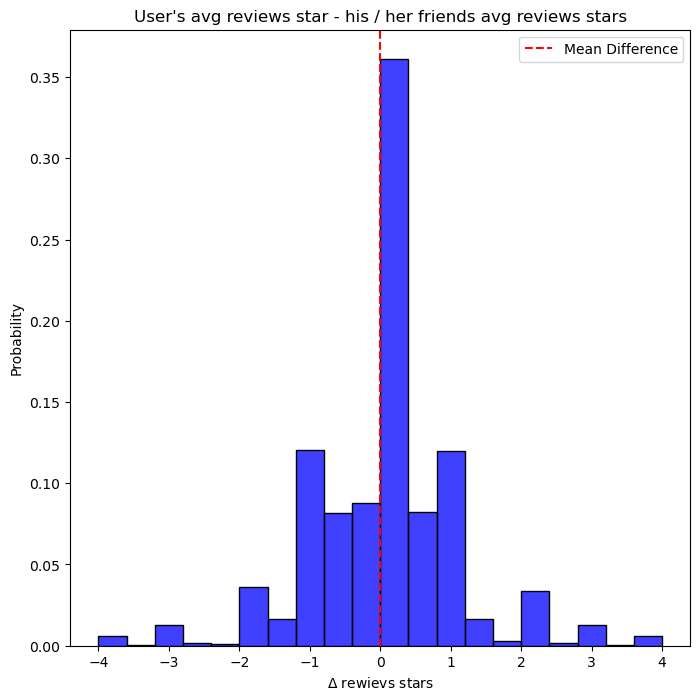

In [ ]:
fig = plt.figure(figsize = (8, 8))

diff = result_df["avg_rating_user"] - result_df["avg_rating_friend"]

sns.histplot(diff, bins = 20, color = "blue", stat = "probability")
plt.axvline(diff.mean(), color = "red", linestyle = "--", label = "Mean Difference")
plt.title("User's avg reviews star - his / her friends avg reviews stars")
plt.xlabel("$\Delta$ rewievs stars")
plt.ylabel("Probability")
plt.legend()

##### ***Query 7***
Find businesses that have increased / decreased the number of checkins in a specific time horizon. Determine, also, the number of reviews and their average stars in that time horizon.

In [ ]:
#Takes a sequence of (years - checkins), checks if years are consecutive and filters on "growth_rate"
def calculate_and_filter_trend(sequence, filter):
    #Retain only the businesses with consecutive years in "sequence"
    window = [s["year"] for s in sequence]
    for i in range(len(window) - 1):
        if window[i + 1] - window[i] != 1:
            return None

    growth = []

    for i in range(1, len(sequence)):
        curr = sequence[i]
        prev = sequence[i - 1]

        growth_rate = (curr["num_checkins"] - prev["num_checkins"]) / prev["num_checkins"]

        if not filter(growth_rate):
            return None

        growth.append({
            "year" : curr["year"],
            "growth" : curr["num_checkins"] - prev["num_checkins"],
            "growth_rate" : growth_rate
        })

    return growth

start = 2010
end = 2020

yearly_checkins = db["businesses_merged"].aggregate([{
                                                         "$unwind" : "$checkins"
                                                     },
                                                     {
                                                         "$addFields" : {
                                                             "year_checkin" : {
                                                                 "$year" : "$checkins"
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$match" : {
                                                             "$and" : [{"year_checkin" : {"$gte" : start}}, 
                                                                       {"year_checkin" : {"$lte" : end}}]
                                                         }
                                                     },
                                                     {
                                                         "$group" : {
                                                             "_id" : {
                                                                 "name" : "$name",
                                                                 "city" : "$city",
                                                                 "year" : "$year_checkin"
                                                             },
                                                             "num_checkins" : {
                                                                 "$sum" : 1
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$sort" : {
                                                             "_id.name" : 1,
                                                             "_id.city" : 1,
                                                             "_id.year" : 1
                                                         }
                                                     },
                                                     {
                                                         "$group" : {
                                                             "_id" : {
                                                                 "name" : "$_id.name",
                                                                 "city" : "$_id.city"
                                                             },
                                                             "checkins_sequence" : {
                                                                 "$push" : {
                                                                     "year" : "$_id.year",
                                                                     "num_checkins" : "$num_checkins"
                                                                 }
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$project" : {
                                                             "_id" : 0,
                                                             "name" : "$_id.name",
                                                             "city" : "$_id.city",
                                                             "checkins_sequence" : 1
                                                         }
                                                     }])

yearly_reviews = db["businesses_merged"].aggregate([{
                                                        "$unwind" : "$reviews"
                                                    },
                                                    {
                                                         "$addFields" : {
                                                             "year_review" : {
                                                                 "$year" : "$reviews.date"
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$match" : {
                                                             "$and" : [{"year_review" : {"$gte" : start}}, 
                                                                       {"year_review" : {"$lte" : end}}]
                                                         }
                                                     },
                                                     {
                                                         "$group" : {
                                                             "_id" : {
                                                                 "name" : "$name",
                                                                 "city" : "$city",
                                                                 "year" : "$year_review"
                                                             },
                                                             "num_checkins" : {
                                                                 "$sum" : 1
                                                             },
                                                             "avg_rating" : {
                                                                 "$avg" : "$reviews.stars"
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$sort" : {
                                                             "_id.name" : 1,
                                                             "_id.city" : 1,
                                                             "_id.year" : 1
                                                         }
                                                     },
                                                     {
                                                         "$group" : {
                                                             "_id" : {
                                                                 "name" : "$_id.name",
                                                                 "city" : "$_id.city"
                                                             },
                                                             "reviews_sequence" : {
                                                                 "$push" : {
                                                                     "year" : "$_id.year",
                                                                     "num_reviews" : "$num_reviews",
                                                                     "avg_rating" : "$avg_rating"
                                                                }
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$project" : {
                                                             "_id" : 0,
                                                             "name" : "$_id.name",
                                                             "city" : "$_id.city",
                                                             "reviews_sequence" : 1
                                                         }
                                                     }])

yearly_checkins = list(yearly_checkins)
yearly_reviews = {(doc["name"], doc["city"]) : doc["reviews_sequence"] for doc in yearly_reviews}

In [149]:
#Process with Python function and filter the result
filter = lambda x : x >= 0.1 #This means: "reatin all businesses with growth rate of at least +0.1"
for doc in yearly_checkins:
    doc["checkins_trend"] = calculate_and_filter_trend(doc["checkins_sequence"], filter)

yearly_checkins = [doc for doc in yearly_checkins if doc["checkins_trend"]]

#Now, combine with the reviews
for doc in yearly_checkins:
    if (doc["name"],  doc["city"]) in yearly_reviews.keys():
        years = [x["year"] for x in doc["checkins_trend"]]
        doc["reviews_trend"] = [x for x in yearly_reviews[(doc["name"],  doc["city"])] if x["year"] in years]

#Final result
yearly_checkins[6]

{'checkins_sequence': [{'year': 2011, 'num_checkins': 37},
  {'year': 2012, 'num_checkins': 83},
  {'year': 2013, 'num_checkins': 100},
  {'year': 2014, 'num_checkins': 118}],
 'name': '168 Chinese & Sushi',
 'city': 'Reno',
 'checkins_trend': [{'year': 2012,
   'growth': 46,
   'growth_rate': 1.2432432432432432},
  {'year': 2013, 'growth': 17, 'growth_rate': 0.20481927710843373},
  {'year': 2014, 'growth': 18, 'growth_rate': 0.18}],
 'reviews_trend': [{'year': 2012, 'avg_rating': 4.146341463414634},
  {'year': 2013, 'avg_rating': 3.857142857142857},
  {'year': 2014, 'avg_rating': 3.5576923076923075}]}

In [158]:
#We'll use a function to not duplicate code across different plots
def plot(dict_to_plot):
    #Extracting data
    years_checkins = [item["year"] for item in dict_to_plot["checkins_sequence"]]
    num_checkins = [item["num_checkins"] for item in dict_to_plot["checkins_sequence"]]

    years_growth = [item["year"] for item in dict_to_plot["checkins_trend"]]
    growth_rates = [item["growth_rate"] for item in dict_to_plot["checkins_trend"]]

    years_ratings = [item["year"] for item in dict_to_plot["reviews_trend"]]
    avg_ratings = [item["avg_rating"] for item in dict_to_plot["reviews_trend"]]

    plt.figure(figsize=(15, 5))

    #Plot for num_checkins
    plt.subplot(1, 3, 1)
    sns.barplot(x = years_checkins, y = num_checkins, color = "blue", )
    plt.title("Yearly number of checkins")
    plt.xlabel("Year")
    plt.ylabel("Number of Cceckins")

    #Plot for growth_rate
    plt.subplot(1, 3, 2)
    sns.barplot(x = years_growth, y = growth_rates, color = "green")
    plt.title("Yearly growth rate")
    plt.xlabel("Year")
    plt.ylabel("Growth rate")

    #Plot for avg_rating
    plt.subplot(1, 3, 3)
    sns.barplot(x = years_ratings, y = avg_ratings, color = "red")
    plt.title("Yearly average ratings")
    plt.xlabel("Year")
    plt.ylabel("Average rating")

    plt.tight_layout()
    plt.show()

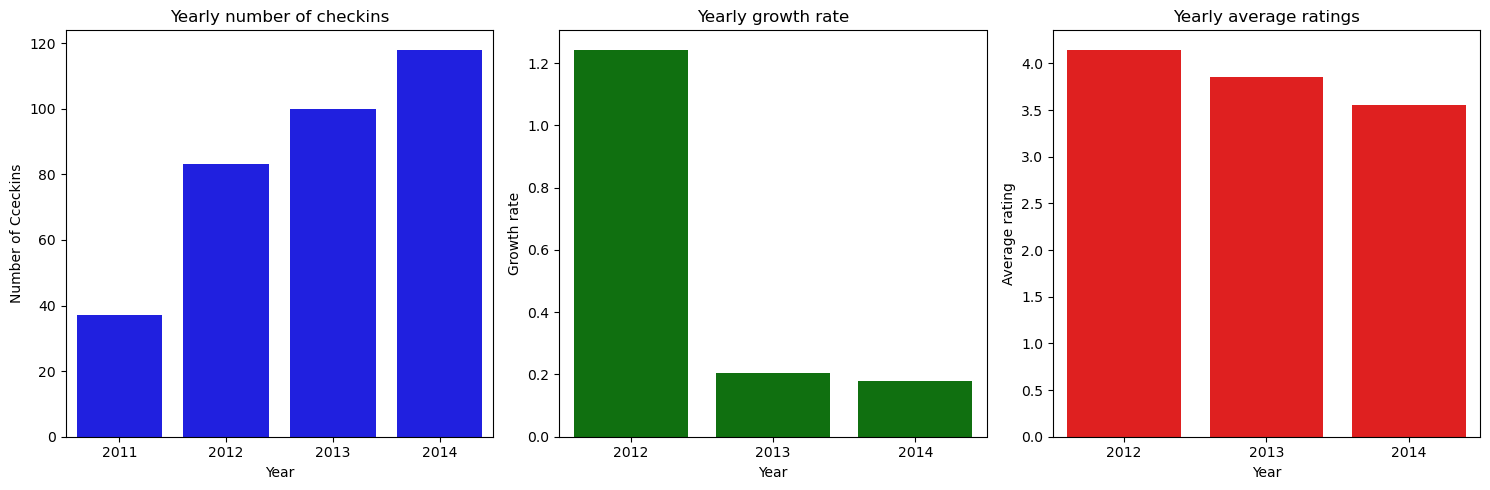

In [159]:
#Plot one random dict of "yearly_checkins" list
plot(dict_to_plot = yearly_checkins[6])

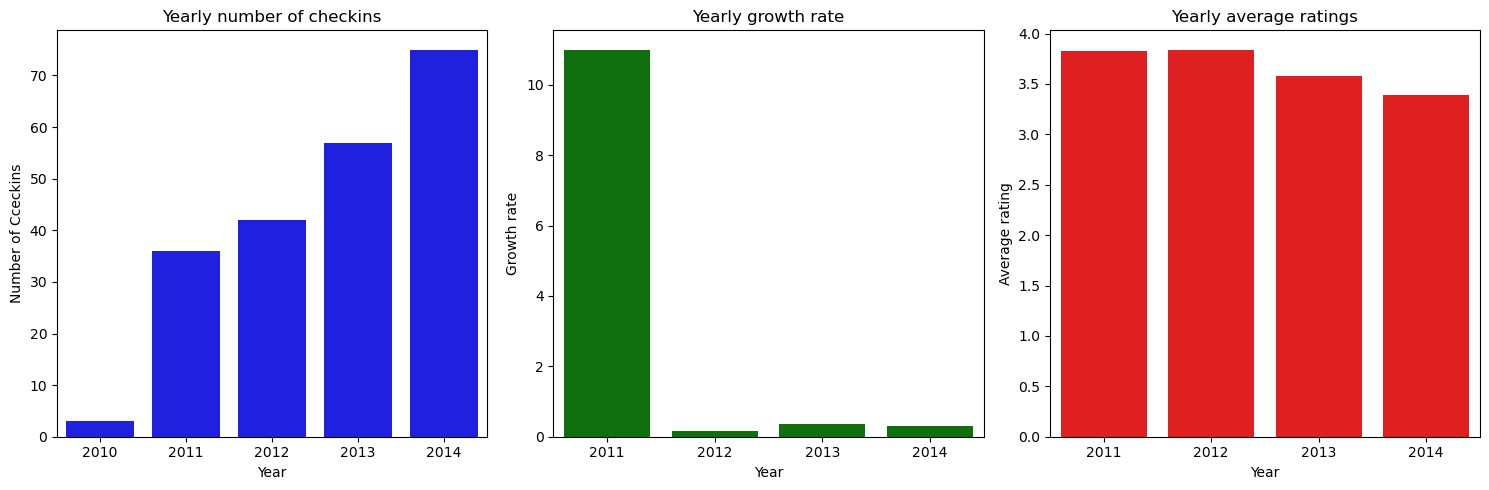

In [168]:
sequences = [(index, item.get("checkins_sequence", [])) for index, item in enumerate(yearly_checkins)]
sequences = [(index, len(item[1])) for index, item in enumerate(sequences)] 
df = pd.DataFrame(sequences, columns=["index", "length"])

#Sort by sequence length in descending order and pick top 5
top_indices = df.sort_values("length", ascending = False).head(5)["index"]

#Retrieve the corresponding dictionaries
top_dicts = [yearly_checkins[i] for i in top_indices]

#Plot for one of top-5
plot(top_dicts[4])